In [303]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from CoolProp.CoolProp import PropsSI

In [304]:
# Datos experimentales
t_exp = np.arange(0, 21, 1) * 60  # en segundos
T_exp = np.array([52, 81.5, 87.1, 90, 91.4, 91.1, 73.9, 81.7, 82.4, 82.5, 82.3, 82.3, 82.8, 74.4, 80.9, 83.1, 84.3, 84.7, 84.6, 83.9, 77.1])
M_exp = np.array([7.3, 7.74, 7.08, 6.24, 5.46, 4.64, 8.32, 7.78, 7.38, 7.04, 6.62, 6.18, 5.68, 8.86, 8.46, 8.08, 7.54, 6.9, 6.32, 5.82, 5.82])

### Intento inicial

In [305]:

# Define parameters
F_max = 0.062444444# Maximum inlet flow (kg/s)
L = 0         # Liquid flow (kg/s)
V_base = 0.008533333    # Nominal vapor flow (kg/s)
x_f = 0.0287       # Mass fraction of salt in F (kg of salt/kg of solution)
x_L = 0.0557      # Mass fraction of salt in L (kg of salt/kg of solution)
rho_f = 1000.0  # Density of the inlet fluid (kg/m³)
h_f_in = 217.13102787427886  # Inlet enthalpy (kJ/kg)
h_i = 418.53341774073357     # Average enthalpy (kJ/kg)
h_v = 2650.8706611904468 # Vapor enthalpy (kJ/kg)
Q = 0.005716667*2256.7       # Added heat (kJ/s)
M_max = 7.36       # Target mass in the evaporator (kg)
M_min = 4.54       # Minimum mass in the evaporator (kg)
c_j = 4.2       # Heat capacity (kJ/kg·K)
T_eb = 357.87   # Boiling temperature (K)


def model(t, y):

    M, M_salt, T = y

    # Control de histéresis
    if M <= M_max:
        F = F_max
    else:
        F = 0
    # If the temperature is below the boiling point, there is no evaporation
    V = V_base if T >= T_eb else 0

    dM_dt = F - V
    dM_salt_dt = F * x_f 
    dT_dt = ((F * (h_f_in - h_i)) - (V * (h_v - h_i)) + Q) / (M_max * c_j)
    
    return [dM_dt, dM_salt_dt, dT_dt]

# Initial conditions
M0 =  0      # Initial mass (kg, less than 7 to allow F input)
M_salt0 = M0*x_f  # Initial salt mass (kg)
T0 = 273.15+52   # Initial temperature (K)
y0 = [M0, M_salt0, T0]

# Simulation time
TIME=20*60
t_span = (0, TIME)  
t_eval = np.linspace(0, TIME, 100)

# Solve the system of differential equations
sol = solve_ivp(model, t_span, y0, t_eval=t_eval, method='RK45')

# Calculate weight-to-weight salt concentration
concentration = (sol.y[1] / sol.y[0])*100
sol.y[2]=sol.y[2]-273.15

C:\Users\ASUS\AppData\Local\Temp\ipykernel_33120\1757565268.py:51: RuntimeWarning: invalid value encountered in divide
  concentration = (sol.y[1] / sol.y[0])*100


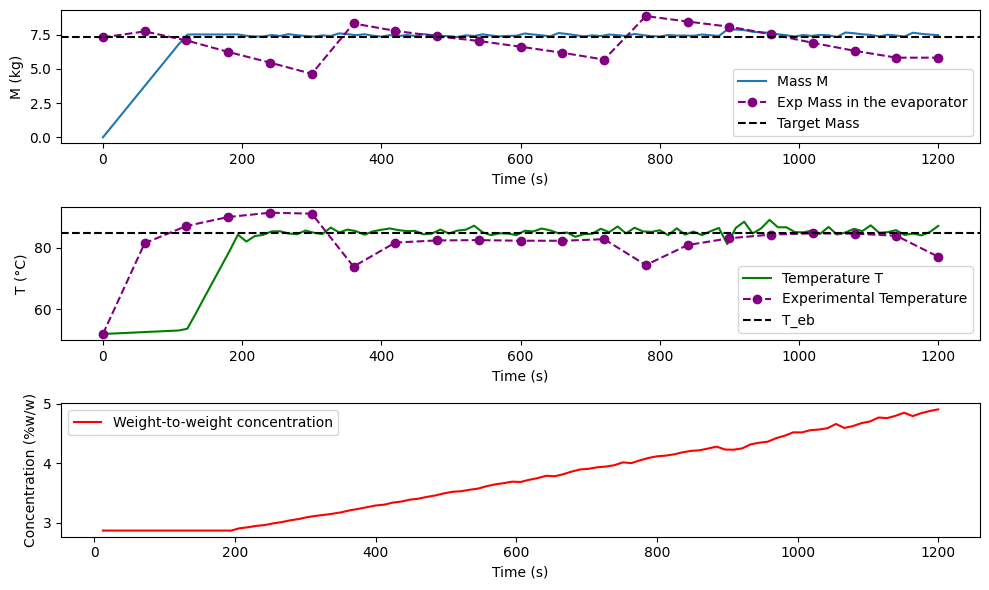

In [306]:
# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(sol.t, sol.y[0], label="Mass M")
plt.plot(t_exp, M_exp, marker='o', linestyle='--', color='purple', label='Exp Mass in the evaporator')
plt.axhline(M_max, linestyle="--", color="black", label="Target Mass")
plt.xlabel("Time (s)")
plt.ylabel("M (kg)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(sol.t, sol.y[2], label="Temperature T", color='g')
plt.plot(t_exp, T_exp, marker='o', linestyle='--', color='purple', label='Experimental Temperature')
plt.axhline(84.72, linestyle="--", color="black", label="T_eb")
plt.xlabel("Time (s)")
plt.ylabel("T (°C)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sol.t, concentration, label="Weight-to-weight concentration", color='r')
plt.xlabel("Time (s)")
plt.ylabel("Concentration (%w/w)")
plt.legend()



plt.tight_layout()
plt.show()


In [327]:
Hv = PropsSI('H', 'P', 57242.13, 'Q', 1, 'Water')  # Produced vapor at P1, T1 without solute
hf = PropsSI('H', 'T', 325, 'P', 74000, 'Water')
hL = PropsSI('H', 'T', 327.87, 'Q', 0, 'Water')  # Liquor enthalpy at T1, xL
hL/1000

229.08481471620593

### Euler con f de entalpía

In [337]:
# System parameters
F_max = 0.067666667  # Maximum inlet flow (kg/s)
L = 0                # Liquid outlet flow (kg/s)
V_base = 0.009759592 # Nominal vapor flow (kg/s)
x_f = 0.0287         # Salt mass fraction in F
x_L = 0.0557         # Salt mass fraction in L
rho_f = 1000.0       # Inlet fluid density (kg/m³)
S = 0.011714928
Q = S * 2256.7       # Added heat (kJ/s)
M_max = 8            # Maximum mass in evaporator (kg)
M_min = 5            # Minimum mass in evaporator (kg)
c_j = 4.2            # Heat capacity (kJ/kg·K)
T_eb = 81.5 + 273.15 # Boiling temperature (K)
P1=57242.13
P=74000
# Enthalpy functions
def h_liquid(T):
    T=T+273.15
    hL=PropsSI('H', 'T', 327.87, 'Q', 0, 'Water')/1000  # Produced vapor at P1, T1 without solute
    return hL  # Liquid enthalpy
def h_vapor(P1):
    Hv = PropsSI('H', 'P', P1, 'Q', 1, 'Water')/1000  # Produced vapor at P1, T1 without solute
    return Hv  # Liquid enthalpy
def h_liquidf(T):
    hF= PropsSI('H', 'T', T, 'P', 74000, 'Water')/1000  # Feed enthalpy at T and P
    return hF  # Liquid enthalpy


# Initial conditions
M = 7.3
M_salt = M * x_f
T = 273.15 + 52  # Initial temp in K
F = F_max

# Simulation settings
dt = 1  # time step (s)
total_time = 20 * 60  # 20 minutes
steps = int(total_time / dt)

# Storage lists
time_list = []
M_list = []
M_salt_list = []
T_list = []
F_list = []
V_list = []
concentration_list = []

# Euler loop with hysteresis
for step in range(steps):
    t = step * dt

    if M >= M_max:
        F = 0
    elif M <= M_min:
        F = F_max

    V = V_base if T >= T_eb else 0
    h_f_in = h_liquidf(290)
    h_i = h_liquid(T)
    h_v = h_vapor(P1)

    dM_dt = F - V
    dM_salt_dt = F * x_f
    dT_dt = ((F * (h_f_in - h_i)) - (V * (h_v - h_i)) + Q - 7) / (M * c_j)

    # Euler integration
    M += dM_dt * dt
    M_salt += dM_salt_dt * dt
    T += dT_dt * dt

    # Save data
    time_list.append(t)
    M_list.append(M)
    M_salt_list.append(M_salt)
    T_list.append(T - 273.15)  # Convert to °C
    F_list.append(F)
    V_list.append(V)
    concentration = (M_salt / M) * 100 if M > 0 else 0
    concentration_list.append(concentration)


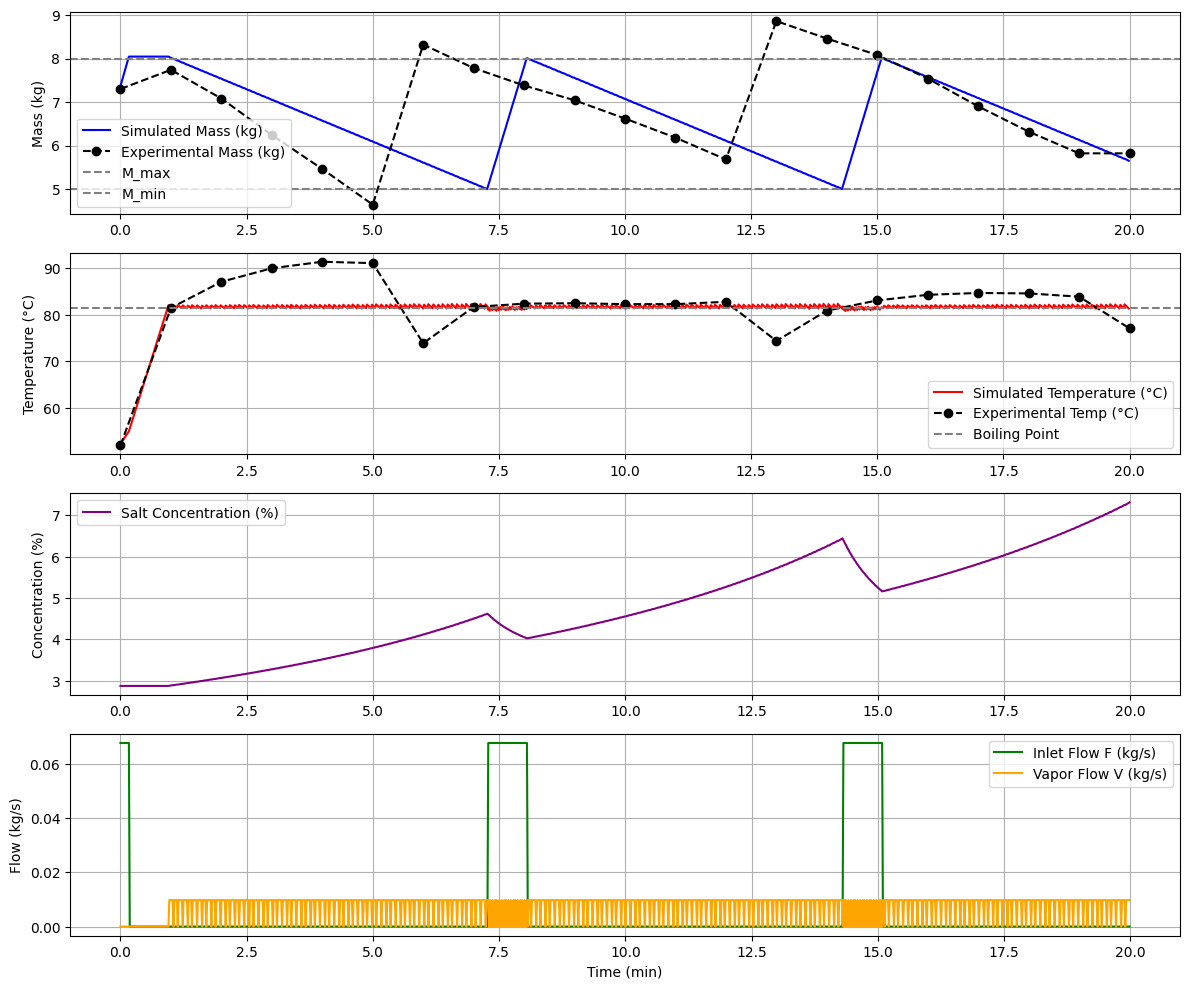

In [338]:
# Convert time to minutes
time_array = np.array(time_list) / 60
T_array = np.array(T_list)
M_array = np.array(M_list)
F_array = np.array(F_list)
V_array = np.array(V_list)
conc_array = np.array(concentration_list)

# Plotting
plt.figure(figsize=(12, 10))

# Mass plot
plt.subplot(4, 1, 1)
plt.plot(time_array, M_array, label='Simulated Mass (kg)', color='blue')
plt.plot(t_exp / 60, M_exp, 'o', linestyle='--',label='Experimental Mass (kg)', color='black')
plt.axhline(M_max, color='gray', linestyle='--', label='M_max')
plt.axhline(M_min, color='gray', linestyle='--', label='M_min')
plt.ylabel('Mass (kg)')
plt.legend()
plt.grid()

# Temperature plot
plt.subplot(4, 1, 2)
plt.plot(time_array, T_array, label='Simulated Temperature (°C)', color='red')
plt.plot(t_exp / 60, T_exp, 'o', linestyle='--',label='Experimental Temp (°C)', color='black')
plt.axhline(T_eb - 273.15, color='gray', linestyle='--', label='Boiling Point')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()

# Concentration plot
plt.subplot(4, 1, 3)
plt.plot(time_array, conc_array, label='Salt Concentration (%)', color='purple')
plt.ylabel('Concentration (%)')
plt.legend()
plt.grid()

# Flow plot
plt.subplot(4, 1, 4)
plt.plot(time_array, F_array, label='Inlet Flow F (kg/s)', color='green')
plt.plot(time_array, V_array, label='Vapor Flow V (kg/s)', color='orange')
plt.xlabel('Time (min)')
plt.ylabel('Flow (kg/s)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()